## INICIALIZAR

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import math  # Para calcular sqrt en max_range
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
import numpy as np
import logging
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
#import skfuzzy as fuzzImport
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score 
from scipy.spatial.distance import cdist
from sklearn.datasets import load_digits

import tiktoken
import random

from openai import OpenAI
from openai import AzureOpenAI

## Search Client

In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
import json
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
import logging
 

# Crea el cliente de búsqueda
credential = AzureKeyCredential(search_api_key)
search_client = SearchClient(endpoint=search_service_url, index_name=index_name, credential=credential)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
# Crea el cliente de búsqueda
credential = AzureKeyCredential(search_api_key)
search_client = SearchClient(endpoint=search_service_url, index_name=index_name, credential=credential)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Common methods

In [ ]:
def search_documents(search_text="*"):
    """
    Realiza una búsqueda en Azure AI Search y devuelve los resultados.
 
    :param search_text: Texto de búsqueda (por defecto es todo).
    :return: Lista de resultados de la búsqueda.
    """
    results = search_client.search(search_text=search_text, top=10)  # Modifica 'top' según tus necesidades
    documents = [result for result in results]
    return documents
# Realizar una consulta
search_results = search_documents("tu texto de búsqueda aquí")
 
# Imprimir los resultados
for doc in search_results:
    print(doc)

def get_all_docs(search_client):
    results = search_client.search(search_text="*", top=None, include_total_count=True)
    documents = [result for result in results]
    return documents



In [ ]:
model = "gpt-4o-mini"
 
assistant = "You are a expert in labeling content to make clusters more easy to select"
api_version = "--------"

client = AzureOpenAI(api_key=apikey, azure_endpoint=endpoint,api_version=api_version)

 
def call_chatgpt_model(prompt, model, assistant):
    """
    LLamada a api de azureopenAI para hacer un prompt y enriquecer las tablas
 
    :param string prompt: prompt que se envía a openAI
    :prarm string model: modelo que se quiere usar de openAI
    """
    try:
        response = client.chat.completions.create(
            model=model,  # model = "deployment_name"
            messages=[
                {"role": "system", "content": assistant},
                {"role": "user", "content": prompt}
            ])
        if not response.choices or not response.choices[0].message or not response.choices[0].message.content:
            print("No valid answer generated")
        # CHATGPT answer:
        answer = response.choices[0].message.content
        return answer
    except Exception as ex:
        msg_error = f"Error generating answer: {ex}"
        print(msg_error)

## Clasificación y Etiquetado

In [ ]:
np.random.seed(42)

def contar_tokens(texto, modelo="gpt-3.5-turbo"):
    # Cargar el codificador específico para el modelo
    codificador = tiktoken.encoding_for_model(modelo)
    # Convertir el texto en tokens
    tokens = codificador.encode(texto)
    # Contar la cantidad de tokens
    cantidad_tokens = len(tokens)
    return cantidad_tokens

# Obtener todos los documentos de la base de datos
def get_all_docs(search_client):
    results = search_client.search(search_text="*", top=None, include_total_count=True)
    documents = [result for result in results]
    return documents

# Obtener todos los embeddings sin agrupar por document_id
def get_all_embeddings(search_client):
    results = get_all_docs(search_client)
    print(f"Embeddings tratados: {len(results)}")
    embeddings = []
    document_ids = []  # Para mantener una referencia a los IDs de los documentos
    document_paths = []  # Para mantener los document_path
    contents = []  # Para mantener el contenido de cada documento
    total_documents = len(results)

    for doc in results:
        document_id = doc.get('id')  # ID del documento (nuevo campo)
        document_path = doc.get('document_path')  # Path del documento
        embedding = doc.get('content_vector')  # Vector de embedding
        content = doc.get('content')  # Contenido del documento

        if embedding is not None:
            embeddings.append(embedding)  # Añadir el embedding directamente a la lista
            document_ids.append(document_id)  # Mantener un registro del document_id
            document_paths.append(document_path)  # Mantener un registro del document_path
            contents.append(content)  # Almacenar el contenido también

    print(f'Número total de documentos en el estudio de cluster: {total_documents} documentos')
    print(f'Número total de embeddings procesados: {len(embeddings)}')

    return np.array(embeddings), document_ids, document_paths, contents  # Devolver también el contenido

# Realizar clustering usando K-Means
def cluster_kmeans(embeddings, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    inertia = kmeans.inertia_  # Inercia
    silhouette_avg = silhouette_score(embeddings, cluster_labels)  # Silhouette Score
    return cluster_labels, inertia, silhouette_avg, kmeans.cluster_centers_

# Función para generar etiquetas llamando al modelo de GPT
def generate_cluster_label(contents):
    prompt = ("Analiza el texto que te voy a proporcionar a continuación y genera una etiqueta que represente el contenido. "
        "Quiero que la etiqueta sea con varias palabras para dar detalle o varias etiquetas, y que clasifique el contenido por temas. "
        "No incluyas la palabra 'Etiqueta' en la respuesta y asegúrate de que no esté en formato de lista. "
        " Etiqueta estar en lenguaje español.\n\n"
    )
    combined_contents = "\n".join(contents)  # Añadir los contenidos
    total_tokens = contar_tokens(prompt) + contar_tokens(combined_contents)

    if total_tokens > 125000:
        # Si excede el límite, truncar o dividir los contenidos
        combined_contents = " ".join(contents)[:125000 - contar_tokens(prompt)]  # Truncar para ajustarse
        contents = [combined_contents]  # Usar el contenido truncado

    prompt += combined_contents  # Añadir el contenido truncado

    # Llamar a la función call_chatgpt_model para obtener la etiqueta
    etiqueta = call_chatgpt_model(prompt, model, assistant)
    return etiqueta

# Procesar los embeddings
embeddings, document_ids, document_paths, contents = get_all_embeddings(search_client)  # Obtener también contenidos

# Rango de k a probar
max_range = len(get_all_docs(search_client))
max_range = int(math.sqrt(max_range) / 2)
k_values = range(10, max_range)
inertia_values = []
silhouette_scores = []

''' # Probar K-Means para cada valor de k
for k in k_values:
    cluster_labels, inertia, silhouette_avg, _ = cluster_kmeans(embeddings, k)
    inertia_values.append(inertia)
    silhouette_scores.append(silhouette_avg)
 
    # Imprimir los valores de inercia y silhouette por cada k
    print(f'k: {k}, Inercia: {inertia}, Silhouette Score: {silhouette_avg}')'''
 
'''# Imprimir el mejor valor de k basado en el Silhouette Score
best_k = k_values[np.argmax(silhouette_scores)]'''
 
# Realizar el clustering final usando el mejor k
final_cluster_labels, _, _, cluster_centers = cluster_kmeans(embeddings, 37)

# Crear un diccionario para contar el número de embeddings en cada clúster
clusters_count = {}
clusters_dict = {}

for label in final_cluster_labels:
    if label not in clusters_count:
        clusters_count[label] = 0
        clusters_dict[label] = []  # Inicializa la lista para este cluster
    clusters_count[label] += 1

# Diccionario para almacenar las etiquetas de los clústeres
cluster_labels = {}
document_labels = []  # Lista para almacenar la info del document_id, document_path, content_vector y etiqueta

for label, count in clusters_count.items():
    print(f'Clúster {label}: {count} embeddings')

    # Obtener los embeddings y el contenido en el clúster actual
    cluster_embeddings = embeddings[final_cluster_labels == label]
    cluster_ids = np.array(document_ids)[final_cluster_labels == label]  # Obtener document_id
    cluster_paths = np.array(document_paths)[final_cluster_labels == label]  # Obtener document_path
    cluster_texts = np.array(contents)[final_cluster_labels == label]  # Obtener contenidos

    # Calcular la distancia de cada embedding al centroide del clúster
    distances = cdist([cluster_centers[label]], cluster_embeddings, metric='euclidean')[0]

    '''# Obtener los 2 embeddings más cercanos al centroide
    closest_indices = np.argsort(distances)[:2]
    closest_ids = cluster_ids[closest_indices]  # Obtener document_id más cercanos
    closest_paths = cluster_paths[closest_indices]  # Obtener document_path más cercanos
    closest_texts = cluster_texts[closest_indices]  # Obtener contenidos más cercanos

    print(f'Los 2 contenidos más cercanos al centroide del clúster {label} son:')
    for i, content in enumerate(closest_paths):
        print(f'  Contenido {i + 1}: {content}')'''

    # Crear un diccionario para almacenar los documentos por clúster
    clusters_dict[label] = []
    for doc_id, embedding, labels, path in zip(document_ids, embeddings, final_cluster_labels, document_paths):
        if labels not in clusters_dict:
            clusters_dict[labels] = []
        clusters_dict[labels].append((doc_id, embedding, path))
        # Calcular el centroide del clúster
    centroid = np.mean(cluster_embeddings, axis=0)
        
        # Calcular la distancia de cada embedding al centroide
    distances = cdist([centroid], cluster_embeddings, metric='euclidean')[0]
        
        # Ordenar los documentos por la distancia al centroide
    sorted_docs = sorted(zip(cluster_ids, distances), key=lambda x: x[1])
        
        # Seleccionar los 100 documentos más cercanos al centroide
    closest_docs = [(doc_id, path) for (doc_id, _), path in zip(sorted_docs[:100], cluster_paths)]
        
        # Seleccionar los 100 documentos más lejanos al centroide
    farthest_docs = [(doc_id, path) for (doc_id, _), path in zip(sorted_docs[-100:], cluster_paths)]
        
        # Obtener el contenido de los documentos más cercanos y más lejanos al centroide
        # Obtener el contenido de los documentos más cercanos y más lejanos al centroide
    closest_contents = [doc_id for doc_id, _ in closest_docs] + [doc_id for doc_id, _ in farthest_docs]

        # Interleave closest and farthest documents
    mixed_contents = []
    min_length = min(len(closest_docs), len(farthest_docs))

    for i in range(min_length):
            mixed_contents.append(closest_docs[i])
            mixed_contents.append(farthest_docs[i])

        # If there are leftover documents in either list, add them
    mixed_contents.extend(closest_docs[min_length:])
    mixed_contents.extend(farthest_docs[min_length:])

        # Extract document paths or contents for labeling
    mixed_contents_texts = [path for _, path in mixed_contents]  # Extracting paths or actual contents

        # Generate a label for the cluster using GPT
    etiqueta = generate_cluster_label(mixed_contents_texts)

    print(f'Etiqueta generada para el clúster {label}: {etiqueta} ')
        
        # Almacenar la etiqueta en el diccionario de clústeres
    cluster_labels[label] = etiqueta

        # Asignar etiqueta a cada documento en el clúster
    for doc_id, doc_path, vector, content in zip(cluster_ids, cluster_paths, cluster_embeddings, cluster_texts):
        document_labels.append({
                "id": doc_id,
                "document_path": doc_path,
                "content_vector": vector,
                "etiqueta": etiqueta
        })

'''# Imprimir las tres primeras entradas de document_labels para verificar
print("\nLas tres primeras entradas del diccionario document_labels:")
for doc in document_labels[:3]:
    print(f"Document ID: {doc['id']}")
    print(f"Document Path: {doc['document_path']}")
    print(f"Content Vector: {doc['content_vector']}")
    print(f"Etiqueta: {doc['etiqueta']}\n")'''

# Actualizar el campo "etiqueta_cluster" en cada documento
results = search_client.search(search_text="*", include_total_count=True)
documentos_para_actualizar = []

# Recorrer todos los documentos y modificar el campo "etiqueta_cluster" con su ID
for doc in results:
    documento_id = doc["id"]  # Asumiendo que el campo 'id' es el identificador único

    # Buscar la etiqueta correspondiente usando el ID del documento
    # Aquí se asume que hay una relación entre `document_labels` y `documento_id`
    etiqueta_correspondiente = next((d['etiqueta'] for d in document_labels if d['id'] == documento_id), None)

    if etiqueta_correspondiente is not None:
        # Crear un nuevo documento que solo contiene el ID y el campo que quieres modificar
        documento_modificado = {
            "id": documento_id,  # El campo 'id' es necesario
            "etiqueta_cluster": etiqueta_correspondiente  # Asignar el nuevo valor a 'etiqueta_cluster'
        }

        # Añadir el documento modificado a la lista de documentos para actualizar
        documentos_para_actualizar.append(documento_modificado)

# Verificar si hay documentos para actualizar
if documentos_para_actualizar:
    # Usar la función merge_documents para actualizar todos los documentos de la lista
    search_client.merge_documents(documentos_para_actualizar)
    print(f"Documentos actualizados: {len(documentos_para_actualizar)}")
else:
    print("No se encontraron documentos para actualizar.")

Ocurrencia de etiquetas

In [ ]:
# Recorrer y obtener todos los valores distintos del campo 'etiqueta_cluster' y contar su ocurrencia
results = search_client.search(search_text="*", include_total_count=True)
cluster_count = {}  # Diccionario para almacenar los valores y sus conteos
count = 0  # Contador total de documentos
for doc in results:
    # Verificamos si el campo 'etiqueta_cluster' existe en el documento
    if "etiqueta_cluster" in doc:
        etiqueta = doc["etiqueta_cluster"]
        if etiqueta in cluster_count:
            cluster_count[etiqueta] += 1  # Incrementamos el conteo de la etiqueta
        else:
            cluster_count[etiqueta] = 1  # Si es la primera vez, lo inicializamos a 1
        count += 1

# Mostramos los valores únicos de 'etiqueta_cluster' y cuántos documentos pertenecen a cada etiqueta
print("Conteo de documentos por etiqueta_cluster:", cluster_count)
print("Total de documentos procesados:", count)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Número de clústeres resultantes: 37


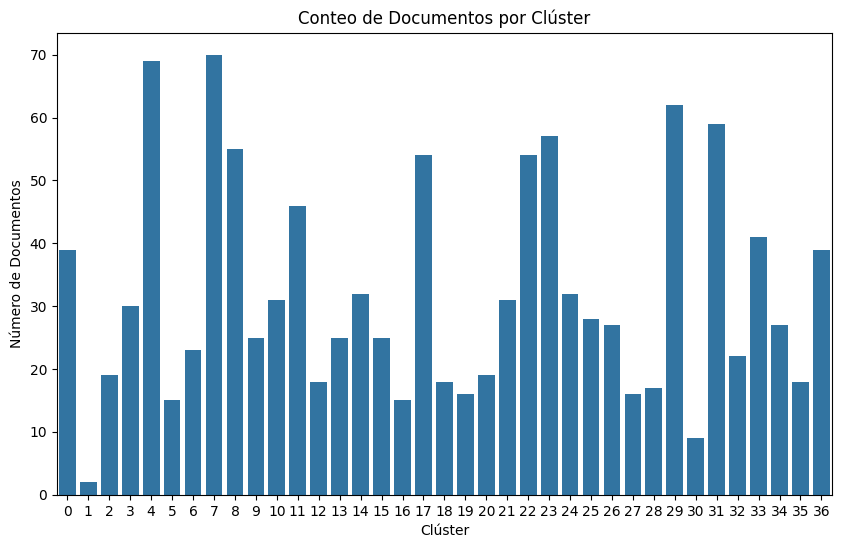

In [19]:

# Suponiendo que `final_cluster_labels` son las etiquetas asignadas por K-Means
unique_labels = np.unique(final_cluster_labels)
num_clusters = len(unique_labels)

print(f"Número de clústeres resultantes: {num_clusters}")
import matplotlib.pyplot as plt
import seaborn as sns

# Contar la cantidad de documentos en cada clúster
cluster_counts = np.bincount(final_cluster_labels[final_cluster_labels != -1])

plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(len(cluster_counts)), y=cluster_counts)
plt.title("Conteo de Documentos por Clúster")
plt.xlabel("Clúster")
plt.ylabel("Número de Documentos")
plt.show()


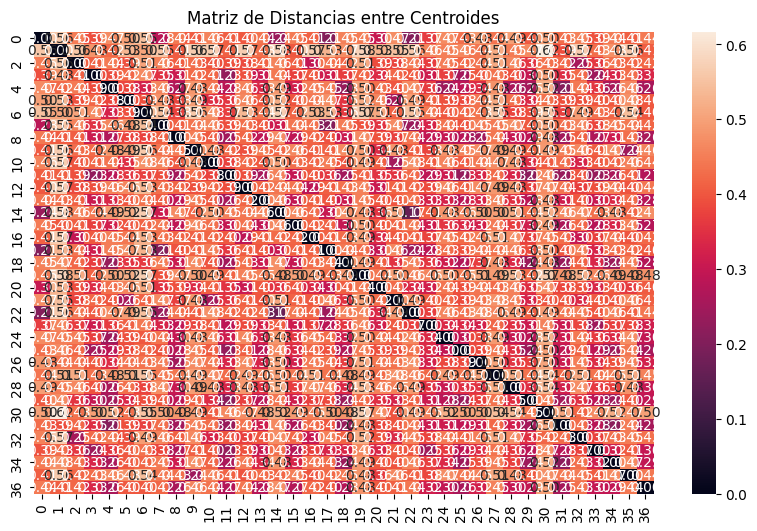

In [20]:
from scipy.spatial.distance import pdist, squareform

# Calcular distancias entre centroides
distances = pdist(cluster_centers, metric='euclidean')
distance_matrix = squareform(distances)

plt.figure(figsize=(10, 6))
sns.heatmap(distance_matrix, annot=True, fmt=".2f")
plt.title("Matriz de Distancias entre Centroides")
plt.show()


## Validación de etiquetas

In [ ]:
np.random.seed(42)

# Función para generar etiquetas llamando al modelo de GPT
def give_embedding_labels(contents):
    prompt = ("CENSURED names of the labels")

    combined_contents = "\n".join(contents)  # Añadir los contenidos
    total_tokens = contar_tokens(prompt) + contar_tokens(combined_contents)

    if total_tokens > 125000:
        # Si excede el límite, truncar o dividir los contenidos
        combined_contents = " ".join(contents)[:125000 - contar_tokens(prompt)]  # Truncar para ajustarse
        contents = [combined_contents]  # Usar el contenido truncado

    prompt += combined_contents  # Añadir el contenido truncado

    # Llamar a la función call_chatgpt_model para obtener la etiqueta
    etiquetas = call_chatgpt_model(prompt, model, assistant)
    return etiquetas

# Procesar los embeddings
embeddings, document_ids, document_paths, contents = get_all_embeddings(search_client)  # Obtener también contenidos

# Lista para almacenar las etiquetas generadas
document_labels = []

# Iterar sobre los contenidos de cada embedding
for content in contents:
    etiqueta = give_embedding_labels(mixed_contents_texts)
    document_labels.append({
        "content": content,
        "etiqueta": etiqueta
    })

# Imprimir las etiquetas generadas para verificar
for doc in document_labels[:5]:
    print(f"Contenido: {doc['content']}\nEtiqueta: {doc['etiqueta']}\n")

'''# Imprimir las tres primeras entradas de document_labels para verificar
print("\nLas tres primeras entradas del diccionario document_labels:")
for doc in document_labels[:3]:
    print(f"Document ID: {doc['id']}")
    print(f"Document Path: {doc['document_path']}")
    print(f"Content Vector: {doc['content_vector']}")
    print(f"Etiqueta: {doc['etiqueta']}\n")'''



### Actualizar etiquetas

In [ ]:
# Actualizar el campo "etiqueta_cluster" en cada documento
results = search_client.search(search_text="*", include_total_count=True)
documentos_para_actualizar = []

# Recorrer todos los documentos y modificar el campo "etiqueta_cluster" con su ID
for doc in results:
    documento_id = doc["id"]  # Asumiendo que el campo 'id' es el identificador único

    # Buscar la etiqueta correspondiente usando el ID del documento
    # Aquí se asume que hay una relación entre `document_labels` y `documento_id`
    etiqueta_correspondiente = next((d['etiqueta'] for d in document_labels if d['id'] == documento_id), None)

    if etiqueta_correspondiente is not None:
        # Crear un nuevo documento que solo contiene el ID y el campo que quieres modificar
        documento_modificado = {
            "id": documento_id,  # El campo 'id' es necesario
            "etiqueta_cluster": etiqueta_correspondiente  # Asignar el nuevo valor a 'etiqueta_cluster'
        }

        # Añadir el documento modificado a la lista de documentos para actualizar
        documentos_para_actualizar.append(documento_modificado)

# Verificar si hay documentos para actualizar
if documentos_para_actualizar:
    # Usar la función merge_documents para actualizar todos los documentos de la lista
    search_client.merge_documents(documentos_para_actualizar)
    print(f"Documentos actualizados: {len(documentos_para_actualizar)}")
else:
    print("No se encontraron documentos para actualizar.")